In [513]:
# from google.colab import drive
# drive.mount('/content/drive')

In [514]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

In [515]:
width = 80
length = 80
batch_size = 48
fill_mode_names = ['nearest' , 'wrap','reflect' ]
epoch = 100

In [516]:
# calling preprocess image lib
train_deg = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.25,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode=fill_mode_names[0],
    rescale=1./255.,
    channel_shift_range = 0.2,
    vertical_flip = True ,
    brightness_range=[0.3, 1.7],  # Example of brightness adjustment
)
tst_deg = ImageDataGenerator(rescale=1./255.)
vld_deg = ImageDataGenerator(rescale=1./255.)

In [517]:
# fitting preprocess lib
train_data = train_deg.flow_from_directory(
    'train' ,
    target_size=(width ,length) ,
    class_mode='categorical' ,
    batch_size=batch_size ,
    shuffle=True,
    color_mode='grayscale'
)
test_data = tst_deg.flow_from_directory(
    'test' ,
    target_size=(width ,length) ,
    class_mode='categorical' ,
    batch_size=batch_size,
    shuffle=True,
    color_mode='grayscale' 
)
valid_data = vld_deg.flow_from_directory(
    'valid' ,
    target_size=(width ,length) ,
    class_mode='categorical' ,
    batch_size=batch_size,
    shuffle=True,
    color_mode='grayscale',
    subset='training',  # Use 'training' for the training set
)

Found 2784 images belonging to 9 classes.
Found 1220 images belonging to 9 classes.
Found 371 images belonging to 9 classes.


In [518]:
# Assuming you have a list of class names
class_names = ['adenocarcinoma', 'brain_tumor','fractured' , 'normal_brain' , 'normal_breast' , 'normal_breast_pneumonia'
               , 'not_fractured', 'pneumoni_breast' , 'unDefined_object' ]

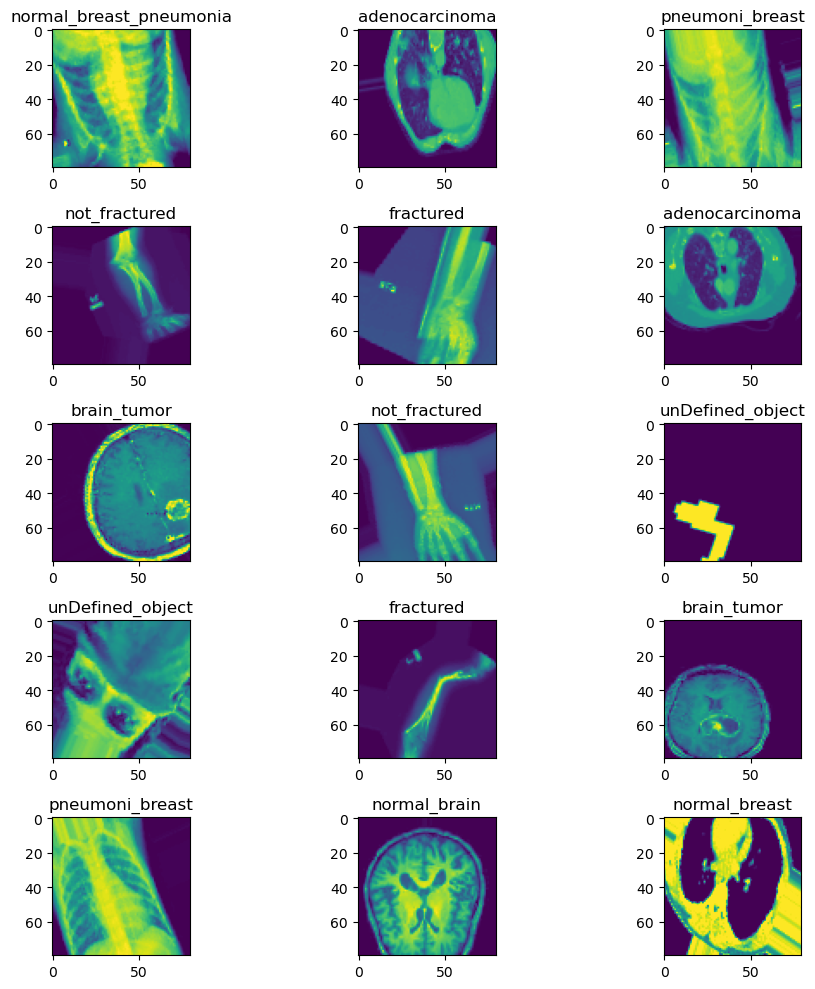

In [519]:
# figure some pics
plt.figure(figsize=(10, 10))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in train_data:
        image = X_batch[0]
        plt.title(class_names[np.argmax(Y_batch[0])])
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [520]:
# callind libary of CNN moel
import keras
from keras.models import Sequential
from keras.layers import Dense , Flatten , Conv2D
from keras.layers import  MaxPooling2D ,BatchNormalization , Dropout , GlobalAveragePooling2D , Input , Activation , AveragePooling2D
from keras.models import Model , load_model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau , LearningRateScheduler



# building RES_NET Model


In [523]:
paddong_in = ['same' , 'valid']
def residual_block(x, filters, kernel_size=(3,3), strides=1):
    
    # Store the input for the skip connection
    shortcut = x
    
    # First convolutional layer
    x = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding=paddong_in[0])(x)
    x = BatchNormalization()(x)
    x = Activation('PReLU')(x)
    
    # Second convolutional layer
    x = Conv2D(filters, kernel_size=kernel_size, strides=1, padding=paddong_in[0])(x)
    x = BatchNormalization()(x)

    # Skip connection
    
    if strides != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=(1,1), strides=strides, padding=paddong_in[1])(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Add the shortcut to the output
    x = keras.layers.add([x, shortcut])
    x = Activation('PReLU')(x)
    return x


In [524]:
input_shape = (width, length, 1)
num_classes = 9

In [525]:
inputs = Input(shape=input_shape)
x = Conv2D(128, kernel_size=(7,7), strides=2, padding=paddong_in[0])(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2,2), strides=2, padding=paddong_in[0])(x)

In [526]:
# Add residual blocks
x = residual_block(x, filters=32)
x = residual_block(x, filters=32)
x = residual_block(x, filters=64, strides=2)
x = residual_block(x, filters=64)
x = residual_block(x, filters=64)  # Uncomment this line if you want to use this block
x = residual_block(x, filters=128, strides=2)
x = residual_block(x, filters=128)
x = residual_block(x, filters=256, strides=2)
x = residual_block(x, filters=256)

x = AveragePooling2D(pool_size=(2, 2), strides=2)(x)
x = Flatten()(x)
outputs = Dense(num_classes, activation='softmax')(x)

In [527]:
model_RES_net = Model(inputs=inputs, outputs=outputs)

In [528]:
loss = ['categorical_crossentropy' , 'custom_loss']
model_RES_net.compile(optimizer=Adam(learning_rate=0.001) , loss=loss[0], metrics=['accuracy'])
model_RES_net.summary()

Model: "model_41"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_59 (InputLayer)       [(None, 80, 80, 1)]          0         []                            
                                                                                                  
 conv2d_1066 (Conv2D)        (None, 40, 40, 128)          6400      ['input_59[0][0]']            
                                                                                                  
 batch_normalization_1064 (  (None, 40, 40, 128)          512       ['conv2d_1066[0][0]']         
 BatchNormalization)                                                                              
                                                                                                  
 activation_841 (Activation  (None, 40, 40, 128)          0         ['batch_normalization_1

                                                                    0]']                          
                                                                                                  
 activation_847 (Activation  (None, 10, 10, 64)           6400      ['add_403[0][0]']             
 )                                                                                                
                                                                                                  
 conv2d_1075 (Conv2D)        (None, 10, 10, 64)           36928     ['activation_847[0][0]']      
                                                                                                  
 batch_normalization_1073 (  (None, 10, 10, 64)           256       ['conv2d_1075[0][0]']         
 BatchNormalization)                                                                              
                                                                                                  
 activatio

                                                                                                  
 add_407 (Add)               (None, 5, 5, 128)            0         ['batch_normalization_1081[0][
                                                                    0]',                          
                                                                     'activation_853[0][0]']      
                                                                                                  
 activation_855 (Activation  (None, 5, 5, 128)            3200      ['add_407[0][0]']             
 )                                                                                                
                                                                                                  
 conv2d_1084 (Conv2D)        (None, 3, 3, 256)            295168    ['activation_855[0][0]']      
                                                                                                  
 batch_nor

In [529]:
def lr_schedule(epoch):
    initial_lr = 0.001  # Initial learning rate
    if epoch < 50:
        return initial_lr
    elif epoch < 100:
        return initial_lr * 0.1
    else:
        return initial_lr * 0.01

# Create a learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

In [530]:
# Callbacks
early_stop = EarlyStopping(patience=100, restore_best_weights=True )
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)
# reduce_lr = ReduceLROnPlateau(factor=0.2, patience=5)

callback = [early_stop , checkpoint , lr_scheduler]

In [531]:
history = model_RES_net.fit(train_data,
                  batch_size=batch_size,
                  epochs=epoch,
                  validation_data=valid_data,
                  callbacks=callback ,
                  shuffle=True ,
                 )


Epoch 1/100
58/58 [==============================] - 90s 1s/step - loss: 1.6376 - accuracy: 0.4325 - val_loss: 2.4523 - val_accuracy: 0.2776 - lr: 0.0010
Epoch 2/100
58/58 [==============================] - 75s 1s/step - loss: 0.9800 - accuracy: 0.6045 - val_loss: 4.9837 - val_accuracy: 0.1644 - lr: 0.0010
Epoch 3/100
58/58 [==============================] - 76s 1s/step - loss: 0.8332 - accuracy: 0.6469 - val_loss: 4.3415 - val_accuracy: 0.1644 - lr: 0.0010
Epoch 4/100
58/58 [==============================] - 75s 1s/step - loss: 0.7234 - accuracy: 0.6749 - val_loss: 3.2083 - val_accuracy: 0.1860 - lr: 0.0010
Epoch 5/100
58/58 [==============================] - 75s 1s/step - loss: 0.6749 - accuracy: 0.7008 - val_loss: 6.0233 - val_accuracy: 0.1887 - lr: 0.0010
Epoch 6/100
58/58 [==============================] - 75s 1s/step - loss: 0.5532 - accuracy: 0.7414 - val_loss: 4.1962 - val_accuracy: 0.2156 - lr: 0.0010
Epoch 7/100
58/58 [==============================] - 76s 1s/step - loss: 0.5

Epoch 54/100
58/58 [==============================] - 76s 1s/step - loss: 0.1903 - accuracy: 0.9188 - val_loss: 0.3030 - val_accuracy: 0.8949 - lr: 1.0000e-04
Epoch 55/100
58/58 [==============================] - 75s 1s/step - loss: 0.1767 - accuracy: 0.9235 - val_loss: 0.3281 - val_accuracy: 0.8760 - lr: 1.0000e-04
Epoch 56/100
58/58 [==============================] - 75s 1s/step - loss: 0.1868 - accuracy: 0.9264 - val_loss: 0.3199 - val_accuracy: 0.8868 - lr: 1.0000e-04
Epoch 57/100
58/58 [==============================] - 75s 1s/step - loss: 0.1841 - accuracy: 0.9188 - val_loss: 0.4511 - val_accuracy: 0.8544 - lr: 1.0000e-04
Epoch 58/100
58/58 [==============================] - 76s 1s/step - loss: 0.1996 - accuracy: 0.9185 - val_loss: 0.2959 - val_accuracy: 0.8976 - lr: 1.0000e-04
Epoch 59/100
58/58 [==============================] - 75s 1s/step - loss: 0.1772 - accuracy: 0.9289 - val_loss: 0.3176 - val_accuracy: 0.8922 - lr: 1.0000e-04
Epoch 60/100
58/58 [==========================

In [534]:
from skimage import transform
from PIL import Image as image1
img= 'beso.jpg'
img = image1.open(img)  #read and of iamge
img = img.convert('L')
np_img = np.array(img).astype('float32')/255  #convert iamge to array
np_img = transform.resize(np_img , (width,length,1)) # resize iamge and proccessing it
np_img = np.expand_dims(np_img, axis=0)
# img.show()
y_pred = model_RES_net.predict(np_img)


img1= 'hazem.jpg'
img1 = image1.open(img1)  #read and of iamge
img1 = img1.convert('L')
np_img1 = np.array(img1).astype('float32')/255  #convert iamge to array
np_img1 = transform.resize(np_img1 , (width,length,1)) # resize iamge and proccessing it
np_img1 = np.expand_dims(np_img1, axis=0)
# img.show()
y_pred_1 = model_RES_net.predict(np_img1)

1/1 [==============================] - 0s 31ms/step


In [2]:
import scipy as sp
gap_weight = model_RES_net.layers[-1].get_weights()[0]
gap_weight.shape
print(gap_weight.shape)
cam_model = Model(inputs = model_RES_net.input , outputs = (model_RES_net.layers[-7].output ,
                                                    model_RES_net.layers[-1].output))
cam_model.summary()

NameError: name 'model_RES_net' is not defined

In [538]:
features , results = cam_model.predict(test_data)
features.shape

26/26 [==============================] - 10s 363ms/step


(1220, 3, 3, 256)

In [539]:
def showcam(i):
    img_idx = i
    feature_for_img = features[img_idx ,: ,:,:]
    predictions = np.argmax(results[img_idx])
    class_activation_weight = gap_weight[:,predictions]
    class_activation_features = sp.ndimage.zoom(feature_for_img , (width/2, length/2 ,1) , order =2)
    cam_output = np.dot(class_activation_features , class_activation_weight)
    print('Predition class : ' + str(predictions) + ' , Probability : ' + str(results[img_idx][predictions]) + ' name : ' + class_names[predictions])
#     plt.imshow(np.squeeze(test_data[img_idx], -1) , alpha=0.5)
    test_images, _ = next(test_data)  # Get a batch of test images

    # Display the first image using plt.imshow
    plt.imshow(test_images[0], alpha=0.5)
    if results[img_idx][predictions] > 0.95:
        cmap_str = 'Greens'
    else:
        cmap_str = 'Reds'
    plt.imshow(cam_output , cmap = cmap_str , alpha=0.5 )
    plt.show()

In [540]:
np.argmax(results[10])

5

Predition class : 0 , Probability : 0.9995432 name : adenocarcinoma


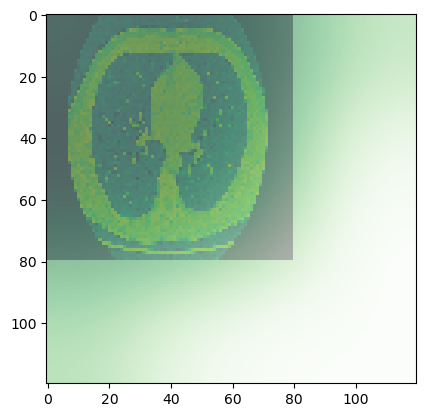

Predition class : 0 , Probability : 0.9958222 name : adenocarcinoma


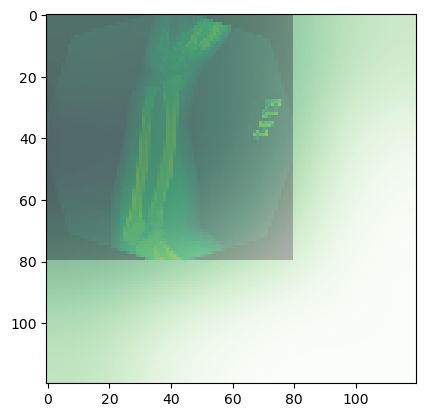

Predition class : 0 , Probability : 0.99996555 name : adenocarcinoma


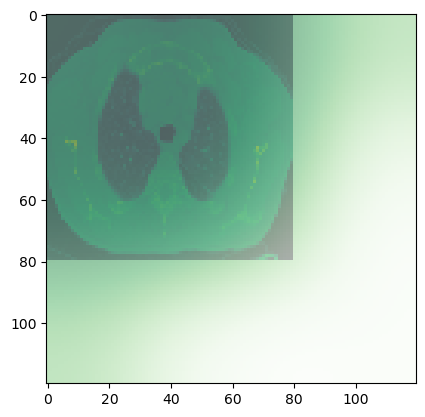

In [541]:
des_class = 0
for i in range(0,14):
    if np.argmax(results[i]) == des_class:
        showcam(i)

In [542]:
model_res = model_RES_net.save('new_model_all.h5')

In [543]:
model_RES_net.evaluate(test_data)
model_res = model_RES_net.save('new_model_all_eval.h5')

26/26 [==============================] - 9s 355ms/step - loss: 0.3464 - accuracy: 0.9033


In [544]:
img12= 'test/normal_breast/normal_breast 18.jpg'
img12 = image1.open(img12)  #read and of iamge
img12 = img12.convert('L')
np_img12 = np.array(img12).astype('float32')/255  #convert iamge to array
np_img12 = transform.resize(np_img12 , (width,length,1)) # resize iamge and proccessing it
np_img12 = np.expand_dims(np_img12, axis=0)
aa= model_RES_net.predict(np_img12)

1/1 [==============================] - 0s 20ms/step


In [545]:
class_names[np.argmax(aa)]

'normal_breast'

In [546]:
saved_model = load_model('new_model_all_eval.h5')

In [547]:
model_save = Model(inputs = saved_model.input , outputs = (saved_model.layers[-7].output ,
                                                    saved_model.layers[-1].output))
model_save.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [548]:
model_save.summary()

Model: "model_43"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_59 (InputLayer)       [(None, 80, 80, 1)]          0         []                            
                                                                                                  
 conv2d_1066 (Conv2D)        (None, 40, 40, 128)          6400      ['input_59[0][0]']            
                                                                                                  
 batch_normalization_1064 (  (None, 40, 40, 128)          512       ['conv2d_1066[0][0]']         
 BatchNormalization)                                                                              
                                                                                                  
 activation_841 (Activation  (None, 40, 40, 128)          0         ['batch_normalization_1

                                                                    0]']                          
                                                                                                  
 activation_847 (Activation  (None, 10, 10, 64)           6400      ['add_403[0][0]']             
 )                                                                                                
                                                                                                  
 conv2d_1075 (Conv2D)        (None, 10, 10, 64)           36928     ['activation_847[0][0]']      
                                                                                                  
 batch_normalization_1073 (  (None, 10, 10, 64)           256       ['conv2d_1075[0][0]']         
 BatchNormalization)                                                                              
                                                                                                  
 activatio

                                                                                                  
 add_407 (Add)               (None, 5, 5, 128)            0         ['batch_normalization_1081[0][
                                                                    0]',                          
                                                                     'activation_853[0][0]']      
                                                                                                  
 activation_855 (Activation  (None, 5, 5, 128)            3200      ['add_407[0][0]']             
 )                                                                                                
                                                                                                  
 conv2d_1084 (Conv2D)        (None, 3, 3, 256)            295168    ['activation_855[0][0]']      
                                                                                                  
 batch_nor

In [549]:
saved_model.fit(train_data , epochs=5 , shuffle = True , validation_data=valid_data )

Epoch 1/5
58/58 [==============================] - 83s 1s/step - loss: 0.1319 - accuracy: 0.9494 - val_loss: 0.3037 - val_accuracy: 0.8976
Epoch 2/5
58/58 [==============================] - 76s 1s/step - loss: 0.1232 - accuracy: 0.9501 - val_loss: 0.3899 - val_accuracy: 0.8868
Epoch 3/5
58/58 [==============================] - 76s 1s/step - loss: 0.1302 - accuracy: 0.9515 - val_loss: 0.4153 - val_accuracy: 0.8760
Epoch 4/5
58/58 [==============================] - 75s 1s/step - loss: 0.1253 - accuracy: 0.9544 - val_loss: 0.2839 - val_accuracy: 0.8976
Epoch 5/5
58/58 [==============================] - 75s 1s/step - loss: 0.1221 - accuracy: 0.9547 - val_loss: 0.4539 - val_accuracy: 0.8571
